Segregation Model

In [8]:
#IMPORTADO DEL REPO DE LA CLASE#

# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [9]:
# Vamos a crear el agente
class SegregationAgent(Agent):
    def __init__(self, id, model, type = 1, threshold = 0.30):
        super().__init__(id, model)
        self.type = type
        #threshold es el límite de comodidad del umbral para el agente
        self.threshold = threshold
        
    #Definir el comportamiento del agente
    def step(self):
        neighbors = self.model.grid.get_neighbors(self.pos, 
                                                    moore = True,
                                                    include_center = False)
        
        #Contar el número de vecinos que son del mismo tipo
        count = 0
        for agent in neighbors:
            if agent.type == self.type:
                count += 1
                
        #Calcular el porcentaje de vecinos que son del mismo tipo
        percentage = 0.0
        if len(neighbors) > 0:
            percentage = float(count) / float(len(neighbors))
            
        if percentage < self.threshold:
            self.model.grid.move_to_empty(self)

In [10]:
# Se genera la grid de la simulación
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for (content, (x, y)) in model.grid.coord_iter():
        if content != None:
            grid[y][x] = int(content.type)
        else:
            # Aquí puedes cambiar la escala de grises
            grid[y][x] = 2
    return grid

In [11]:
# Ahora haremos el modelo
class SegregationModel(Model):
    def __init__(self, width, height, empty_cells = 0.2, threshold = 0.3):
        self.grid = SingleGrid(width, height, torus = True)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters = {"Grid": get_grid}
        )
        
        id = 0
        
        num_agents = int((width * height) * (1 - empty_cells))
        while self.grid.exists_empty_cells():
            agent = SegregationAgent(id, self, np.random.choice([0, 1]), threshold)
            self.grid.move_to_empty(agent)
            self.schedule.add(agent)
            
            id += 1
            if id > num_agents:
                break
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [12]:
#El modificar el Threshold y el Empty_cells modificará el resultado.

GRID_SIZE = 55
MAX_ITERATIONS = 100
# El threshold es el porcentaje de vecinos que deben ser iguales al agente para que este se sienta satisfecho
TRESHOLD = 0.8
# El porcentaje de celdas vacias
EMPTY_CELLS = 0.2

model = SegregationModel(GRID_SIZE, GRID_SIZE, EMPTY_CELLS, TRESHOLD)
for i in range(MAX_ITERATIONS):
    model.step()

In [13]:
all_grid = model.datacollector.get_model_vars_dataframe()

MovieWriter imagemagick unavailable; using Pillow instead.


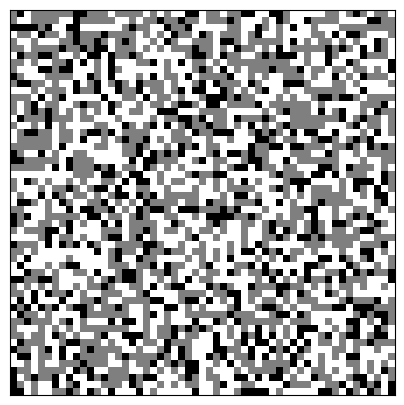

In [14]:

fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([]) 
axis.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(
    fig, animate, frames=MAX_ITERATIONS)

# La animación se guarda como GIF, para verla, abre el archivo creado en esta misma carpeta.
anim.save('segregation_model.gif', writer='imagemagick', fps=10)